In [1]:
import os

from astropy.visualization import hist
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.cosmology import WMAP9 

import numpy as np
import pandas as pd

import scipy.stats as st
from scipy.signal import find_peaks
import scipy.optimize 
 
import matplotlib.pyplot as plt
import matplotlib as mpl

import emcee
import corner

from copy import deepcopy

from importlib import reload

import warnings
warnings.filterwarnings("ignore")

**Define paths to directories**

In [2]:
path = "/home/maria/Dropbox/GRB_rings/"
path_plots =  "/home/maria/Dropbox/GRB_rings/plots/"

os.chdir(path)
file_names = ['sw004_1', 'sw005_1', 'sw006_1', 'sw006_2', 'sw006_3', 'sw006_4', 'sw008_1', 'sw008_2', 'sw008_3', 'sw009_1']

**imports functions from user-defined library**

In [3]:
import profiler

**reading time of XRT observations**

In [4]:
time = np.zeros(len(file_names))
time_err_lo = np.zeros(len(file_names))
time_err_hi = np.zeros(len(file_names))

for i in range(0, len(file_names)):
    file = 'split_evt/' + file_names[i]+'.evt'
    time_temp, time_err_temp = profiler.time_reader(file)
    time[i] = time_temp[0]
    time_err_lo[i] = time_err_temp[0][0]
    time_err_hi[i] = time_err_temp[0][1]

**reading optimal parameters from MCMC fit to individual XRT data**

In [5]:
# From Data_params-MP-new-2.txt
# copy paste here values from Data_params*txt files

params_fin = [[0.03520655999519709, 2.4656962320478257, 0.2983802928139838, 0.005799715071763458, 3.3418079001616716, 0.17291140960995874, 0.03129548733890883, 5.6998358158491484, 0.2779586205988884, 0.02904969411026442, 7.065852194764932, 0.4384024749757559, 0.010391606422909904, 7.614688026666218, 0.21513955890836206, 0.003129820901201439, 11.739129338063739, 0.8574774897778502],
[0.03111247996014366, 2.589780577726537, 0.3193096220486427, 0.003920647449971455, 3.56370786432684, 0.16065417724382922, 0.019140656682988033, 5.970728143317732, 0.23432231911581988, 0.029731440050758205, 7.551005749781985, 0.4497814898247241, 0.002502006805365734, 12.321025887819479, 0.4234858991196224],
[0.03235685121258432, 2.5778611170963206, 0.4095459468522843, 0.0029754427688597875, 3.648313408118975, 0.14806552940964962, 0.020602591226126694, 6.241927345754229, 0.3659910494231485, 0.017493774441155425, 7.916004401678501, 0.4598054356881779, 0.0030664459312085128, 13.114364546962543, 0.4638484772448495],
[0.02959132100974301, 2.8382193121010046, 0.4081561677251712, 0.005043715443403263, 3.914316435408407, 0.2969622582007307, 0.01837057012303279, 6.628782390082236, 0.3536023475514501, 0.02059754386675414, 8.41284171715699, 0.4964849526965329, 0.0017796390602202597, 13.47280444653326, 0.416375785799194],
[0.024847580440093685, 3.1159589360723903, 0.43115344429471664, 0.003646463662331228, 4.178001617787391, 0.2972863194864772, 0.016112258904169813, 7.114452666703998, 0.3627073299034008, 0.013323218844717292, 9.058115552948625, 0.49330948123614515, 0.0009228627901574157, 14.391885052793285, 0.28347307602988536],
[0.0180798789005355, 3.242424315945173, 0.33617357711097084, 0.0037339106364780985, 4.418947809219043, 0.2513702824279532, 0.011895850725922131, 7.481921494615208, 0.3455409711500742, 0.011045210128467936, 9.470278138112084, 0.4970401571321476, 0.0007167272928209161, 14.920294093673158, 0.2488634048643989],
[0.01523380148561661, 3.821526193592953, 0.4548164560219009, 0.002452319467908877, 5.177608907025788, 0.21440856199182598, 0.007361297011110712, 8.714333043156568, 0.34599875051793666, 0.007457925395452437, 10.755330118384057, 0.4934593850907542],
[0.013347134673703093, 4.079253055531118, 0.48197189221981157, 0.0018026093117679155, 5.520142343445053, 0.31864672783958115, 0.006834698661817102, 9.12718366340009, 0.3139252182875586, 0.005741735095782256, 11.43576957991126, 0.46240827236539095],
[0.00895586578686838, 4.153711167416914, 0.4574773120732436, 0.0011677459705057322, 5.949514327710714, 0.1782168631269326, 0.006027038140778408, 9.66058171275962, 0.391322476039649, 0.004098985315350187, 12.559371430119267, 0.46604129731773186],
[0.010163503789297335, 4.492739541181886, 0.46643492646373635, 0.0011751963582880259, 6.080454141307199, 0.2151276654104547, 0.003846174751217008, 10.162580752284022, 0.45949670755549155, 0.0025189661426258877, 12.559112416543014, 0.48452968925743434]
]

fit_err = [[[0.0026243185744360964, 0.0028258997723469292],
  [0.017451976190544283, 0.017044250837357833],
  [0.02714889479234417, 0.030250017001550333],
  [0.001019162248279571, 0.0011254463587541327],
  [0.0365929588379057, 0.028587547663116553],
  [0.03673550493182384, 0.040248123656800305],
  [0.001094000024157507, 0.0010797470109298393],
  [0.008722478438307313, 0.009335837388331214],
  [0.012894147958297797, 0.012876365207632245],
  [0.0025238882224114523, 0.0024115366250876263],
  [0.02835781707069618, 0.028101206736519835],
  [0.030383481429688275, 0.02845272307814939],
  [0.0016315626222692288, 0.0018578359312180406],
  [0.020160914891132364, 0.018780142146225032],
  [0.025429080736761922, 0.027755370517325656],
  [0.0009171147825860972, 0.0008504566284204206],
  [0.1673168488213257, 0.17712675118958465],
  [0.20341249402624595, 0.10053485140958307]],
 [[0.0027023390024955435, 0.0028063594057291807],
  [0.026266283260882872, 0.02638855839829235],
  [0.034220657196265825, 0.041984962569199646],
  [0.0010624803332780976, 0.0010803831870599876],
  [0.04995213057759873, 0.04843077873736057],
  [0.04138630388473209, 0.07248887200212564],
  [0.0012396142604555356, 0.0013281893252072297],
  [0.016975115393114137, 0.019251647760608392],
  [0.02216736112886819, 0.02394606708321359],
  [0.0015316073955493371, 0.0016182561875262222],
  [0.025621465041665736, 0.02593687528447397],
  [0.030891371873940865, 0.02763975439628691],
  [0.0008410033878245577, 0.000831020848082903],
  [0.14525300423919774, 0.179314706809647],
  [0.13944018169791045, 0.0655048852266738]],
 [[0.0024394151463939875, 0.0024352897445445026],
  [0.011915049193270022, 0.006029862397405772],
  [0.04215082445642998, 0.04203086149447843],
  [0.0007703153510280119, 0.0010704861697235927],
  [0.052548189190642525, 0.04113057794873498],
  [0.04221528304001648, 0.11792658483837323],
  [0.0010830716340374767, 0.0011085046654449732],
  [0.01578360762631803, 0.015738463317340745],
  [0.024815559203952453, 0.027996359217305866],
  [0.001010741283629591, 0.0009521437978723263],
  [0.028491450765217863, 0.027489016133082522],
  [0.02716907466349705, 0.026222987425260136],
  [0.0007238634471645302, 0.000706510176015205],
  [0.1436889423726928, 0.39560978174491446],
  [0.09040932431107174, 0.0440308339504748]],
 [[0.0027337517073743323, 0.0025222973976452567],
  [0.02756719362413529, 0.02874651490733182],
  [0.04496027630227806, 0.0469316546069205],
  [0.0013534595498711317, 0.0017699837659917667],
  [0.06930804845215777, 0.06080880385051257],
  [0.08660300153056419, 0.11041833854136746],
  [0.0008439746460548181, 0.0008901954877371561],
  [0.015458864367883685, 0.015485075662065029],
  [0.025947627487458658, 0.02775875393382904],
  [0.000694813033023628, 0.0006960337579250721],
  [0.028621110038647757, 0.027284570693893784],
  [0.005900907607696737, 0.0026167484378615824],
  [0.0004322144156239376, 0.00042850240105567227],
  [0.13124566367693724, 0.12047343096099539],
  [0.09786694533771573, 0.06182759201341914]],
 [[0.0017037180005733225, 0.0016504419324307011],
  [0.021297818613086328, 0.02211973444664128],
  [0.03908122687212162, 0.038839621029440885],
  [0.000839310772519732, 0.000976912871932759],
  [0.04650424317076318, 0.052746439051085225],
  [0.07642136207300074, 0.09246242288625006],
  [0.0005634753265760899, 0.0005602334703716169],
  [0.012959213200435471, 0.013832090000818198],
  [0.0182613226330271, 0.019503036821978015],
  [0.0004988073634278525, 0.0005072390032452006],
  [0.02588261170756212, 0.024942261712830316],
  [0.010923167098256359, 0.005076633316952017],
  [0.0002729187472543045, 0.0002905192938938597],
  [0.07570879712362633, 0.06930497055325091],
  [0.09619233682088413, 0.11565780736442788]],
 [[0.000898334544780912, 0.0010104411413855013],
  [0.01726072669330314, 0.01766258375051244],
  [0.026100838699504803, 0.026551267577864135],
  [0.0004620444673681329, 0.0005259640863830425],
  [0.028593984890307844, 0.03060746372968648],
  [0.03840229580668472, 0.04398024964871022],
  [0.0004388635647214704, 0.00043196170582111837],
  [0.012301290756032479, 0.012670594204394092],
  [0.018379650959187144, 0.017666121720084582],
  [0.0003600568520363036, 0.0003623854883230797],
  [0.028840894537141892, 0.02864102734048224],
  [0.005158113948335985, 0.002071639369252809],
  [0.00020840357729230122, 0.0002237827569392842],
  [0.07547312261130301, 0.11296817796483971],
  [0.08830924542084442, 0.10170445211103157]],
 [[0.0010080747791930272, 0.0009604828366793199],
  [0.02887194908967583, 0.028984792799671588],
  [0.04062540747141885, 0.031059425779526806],
  [0.00043389474940348175, 0.0004939826641702227],
  [0.045421357967748044, 0.04106829784568866],
  [0.04752415245127806, 0.05812162325986536],
  [0.00043284510588903913, 0.00042698424776626154],
  [0.021166669734933308, 0.02161908604357876],
  [0.02426417668280484, 0.0287090796487115],
  [0.00042340400192067244, 0.00042433046322288854],
  [0.04736415339482569, 0.05101006824408039],
  [0.011420093590855496, 0.005234389755546298]],
 [[0.0010830269654642927, 0.0009878070909575456],
  [0.05233473374348829, 0.049616764555963755],
  [0.02760649600528503, 0.01328220231329974],
  [0.0005500849892329329, 0.0005457226812804554],
  [0.09456937446225844, 0.08738598861740332],
  [0.1018092501805391, 0.11182470129084648],
  [0.0005948700579776348, 0.0005560575957507634],
  [0.03004397518957802, 0.0297087747679452],
  [0.03557876422474465, 0.04054540995291728],
  [0.0006289360557728812, 0.0006020882856315876],
  [0.05810005301305132, 0.05950492363739279],
  [0.04553358473329955, 0.02515701199252851]],
 [[0.0010280853333844448, 0.0010118065203467645],
  [0.07042963136038782, 0.0632069316498729],
  [0.04858091479110466, 0.028921561635536275],
  [0.00041997877753030197, 0.00042648647480341036],
  [0.08763467183013862, 0.06141167573663697],
  [0.055269376753950245, 0.1346989612587295],
  [0.0007769186300528716, 0.000767648622092533],
  [0.05267598865244949, 0.054944625524187884],
  [0.07063885231357492, 0.06680701352681334],
  [0.0006985109147295732, 0.0007031272875500996],
  [0.18157349213226937, 0.14501789983028068],
  [0.04961451192485278, 0.02765364008642629]],
 [[0.0005003775770696384, 0.00050505766036287],
  [0.024128059699367377, 0.02380248064988333],
  [0.03433824119145845, 0.022384466605773756],
  [0.00023261716004165534, 0.00024321915259950576],
  [0.06958002332904911, 0.05380865807654711],
  [0.04695967824213587, 0.04917831918364193],
  [0.00031651141040211833, 0.0003006173083148376],
  [0.0471412425344937, 0.04825811827923765],
  [0.044228503016870535, 0.029005324841070546],
  [0.00027020252410123527, 0.0002796260185627163],
  [0.10885816673381754, 0.12672338946596184],
  [0.025487548232489166, 0.012013326407833758]] 
 ]


# Definition of models and likelihood functions

In [34]:
def model3(params, t):
    t_0 = params[0]
    dl_norm=[]
    result=[]
    for k in range(1,len(params)):
        dl_norm.append(params[k])
    for i in range(0,len(ind_com)-1):
        t_temp=t[ind_com[i]:ind_com[i+1]]
        result=np.append(result,np.array(profiler.ring_rad(t_temp,dl_norm[i],t_0)))
    return np.array(result)
    
def lnlike3(p, t, y, yerr):
    return -0.5 * np.sum(((y - model3(p, t))/yerr) ** 2)

def lnprior3(p):
    t_0 = p[0]
    nr=[]
    for k in range(1,len(p)):
        nr.append(p[k])
    check=True
    for m in range(0,len(nr)):
        if x_min[m]>nr[m] or nr[m]>x_max[m]:
            check=False
            break
    if (check==True and t0_min<t_0<t0_max):
        pass
    else:
        return -np.inf
    return 0.0

def lnprob3(p, x, y, yerr):
    lp = lnprior3(p)
    return lp + lnlike3(p, x, y, yerr) if np.isfinite(lp) else -np.inf

def lnlike3_gv(p, t, y, yerr):
    II = len(p)
    log_f = p[II - 1]
    params1 = p[0: II-1]
    sigma = yerr ** 2 + np.exp(2 * log_f)
    like = -0.5 * np.sum((y - model3(p, t)) ** 2 / sigma + np.log(sigma))
    return like

def lnprob3_gv(p, x, y, yerr):
    lp = lnprior3(p)
    return lp + lnlike3_gv(p, x, y, yerr) if np.isfinite(lp) else -np.inf

###############################################
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for th in thetas:
        mod = profiler.ring_rad(x_model,th[1],th[0])
        models.append(mod)
    spread = np.nanstd(models,axis=0)
    med_model = np.nanmedian(models,axis=0) 
    return med_model,spread
##############################################

# Running MCMC 

[1.23470147e-05 5.98616356e+04]
[6.54100436e-06 5.98616406e+04]
[2.46174868e-06 5.98615324e+04]
[1.55793638e-06 5.98615228e+04]
[6.69780511e-07 5.98613330e+04]
Running burn-in...
Running production...


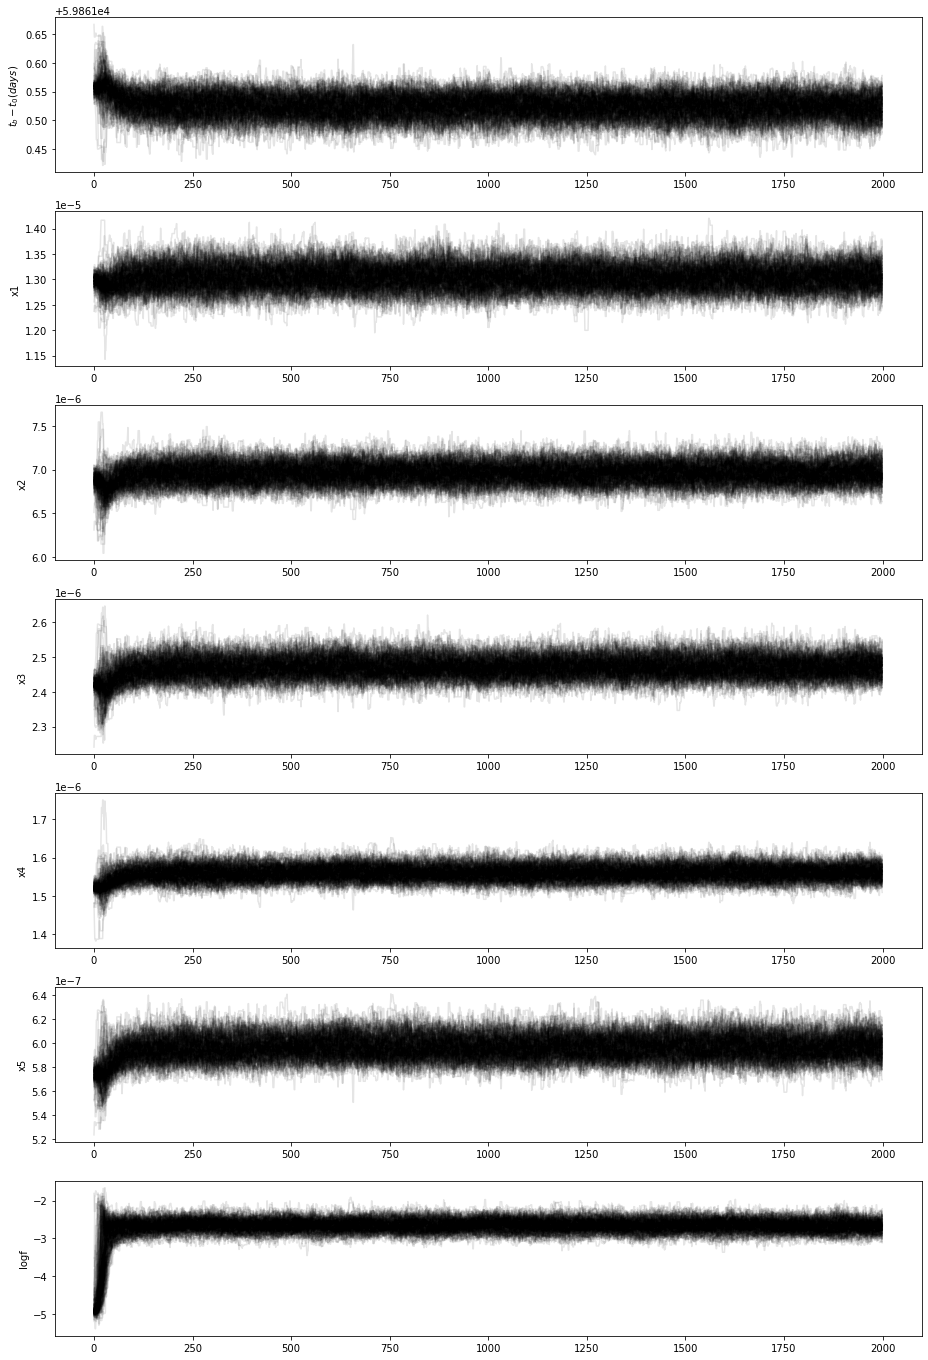

In [7]:
cmap = plt.cm.tab10

t_bat=int(59861.59047454)
t_gbm=int(59861.55)
t_ref=t_gbm

ttime=np.linspace(time[0],time[-1],500)
ring_d=np.zeros(shape=(int((len(params_fin[0]))/3)-1,len(time)))

for i in range(0,len(params_fin)):
    for j in range(0,int((len(params_fin[i]))/3)):
        if i==0:
            if j==4:
                pass
            if j>4:
                ring_d[j-1][i]=params_fin[i][3*j+1]
            if j<4:
                ring_d[j][i]=params_fin[i][3*j+1]   
        else:
            if i==2:
                ring_d[j][i]=params_fin[i][3*j+1]
            else:
                ring_d[j][i]=params_fin[i][3*j+1]
        
tfit=[]
for j in range(0,int((len(params_fin[1]))/3)):
    mask=(np.isnan(ring_d[j]))|(np.array(ring_d[j])==0.)
    guess=[10**(-5.),58961.]
    if j==4: guess=[10**(-7.),58961.]
    fparams,pconv=scipy.optimize.curve_fit(profiler.ring_rad,np.array(time[~mask]),ring_d[j][~mask],p0=guess,maxfev=500000)
    print(fparams)
    tfit.append(fparams)
    

t_com=[]
y_com=[]
y_err_com=[]
ind_com=[0]

for i in range(0,len(ring_d)):
    mask=(np.isnan(ring_d[i]))|(np.array(ring_d[i])==0.)
    t_com=np.append(t_com,np.array(time)[~mask])
    y_com=np.append(y_com,np.array(ring_d)[i][~mask])
    temp=[]
    ind_com.append(ind_com[-1]+len(np.array(time)[~mask]))
    for j in range(0,len(np.array(time)[~mask])):
        temp.append(max(fit_err[j][i*3+1]))
    y_err_com=np.append(y_err_com,np.array(temp))

in_params=[tfit[0][1]]
for i in range(0,len(tfit)):
    in_params.append(tfit[i][0])


params_names=["$t_b-t_{0}(days)$"]
for k in range(0,len(ring_d)):
    params_names.append('x'+str(k+1))

t=t_com
y=y_com
yerr=np.array(y_err_com)

data = (t,y,yerr)

x_min=[]
x_max=[]

for i in range(1,len(in_params)):
    x_min.append(0.1*in_params[i])
    x_max.append(5.*in_params[i])
    
t0_min=59861
t0_max=59862

nwalkers = 200

in_params = np.append(in_params,-5)
x_min.append(-10)
x_max.append(-0.5)
params_names.append('logf')

initial = np.array(in_params)
ndim = len(initial)
p0 = [np.array(initial) + (10**(-2.),*(10**(-8.)*np.ones(len(initial)-1)).tolist()) * np.random.randn(ndim)
      for k in range(nwalkers)]

# code them in a matrix
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3_gv, args=data)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000)


plt.figure(figsize=(13,19))
# for each parameter...
for k in range(ndim):
    param_name = params_names[k]
    plt.subplot(ndim, 1, k + 1)
    # ...plot all chains
    for i in range(nwalkers):
        chain = sampler.chain[i, :, k]
        plt.plot(chain, "k", alpha=0.1)
    plt.ylabel(param_name)
plt.tight_layout()
plt.show()


In [26]:
n_burnin = 750

percentage_to_plot = 1.0

converged_chain = sampler.chain[:, n_burnin:, :]
flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)

params_names=["$t_b-%d (days)$"%(t_ref)] 
logx=[]
divx=[]
for k in range(0,len(ring_d)):
    x_temp=deepcopy(flat_converged_chain[0][k+1])
    if abs(np.log10(x_temp))%1==0:
        logx.append(np.log10(x_temp))
    else:
        if np.log10(x_temp)<0:
            logx.append(round(np.log10(x_temp)+abs(np.log10(x_temp))%1-1.))
        else:
            logx.append(round(np.log10(x_temp)-abs(np.log10(x_temp))%1))
    divx.append(round(10**(np.log10(x_temp)%1),2))
    params_names.append("$x_{%d}$ $(10^{%d})$"%(k+1,logx[-1]))

params_names.append('logf')

optimal_parameters = []
  
tfit3=[]
tfit3_err=[]
fgc3_ring=[]
 
for dim in range(ndim):
    converged_values = sampler.chain[:, n_burnin:, dim].flatten()
    optimal_value = np.median(converged_values)
    print("{} = {:.6g}".format(params_names[dim], optimal_value))
    optimal_parameters.append(optimal_value)  


tfit3.append(optimal_parameters)

quantiles=[0.16, 0.5, 0.84]  
q=[]
for j in range(0,len(in_params)): 
    for i in range(0,len(quantiles)):
        q.append(np.quantile(flat_converged_chain[:,j], quantiles[i]))
    
temp=[]
for k in range(0,len(q),3):
    temp.append([abs(q[k+1]-q[k]),abs(q[k+1]-q[k+2])])
    
tfit3_err.append(temp)
fgc3_ring.append([flat_converged_chain])

$t_b-59861 (days)$ = 59861.5
$x_{1}$ $(10^{-5})$ = 1.30375e-05
$x_{2}$ $(10^{-6})$ = 6.96124e-06
$x_{3}$ $(10^{-6})$ = 2.4697e-06
$x_{4}$ $(10^{-6})$ = 1.55959e-06
$x_{5}$ $(10^{-7})$ = 5.96451e-07
logf = -2.66911


**Print the burst time and layer distances**

In [32]:
z = 0.151
cosmo2 = WMAP9 
dL2 = cosmo2.luminosity_distance(z)

print(tfit3[0][0])
print(np.array(tfit3_err[0][0]))

for j in range(1,len(in_params)-1):
    print(tfit3[0][j])
    print(np.array(tfit3_err[0][j]))
    print(tfit3[0][j]*dL2.value*1e3)
    print(np.array(tfit3_err[0][j])*dL2.value*1e3)

59861.52503550415
[0.01939733 0.01818993]
1.3037547174637869e-05
[2.18855933e-07 2.25172737e-07]
9.471970712609586
[0.15900207 0.16359132]
6.961235144433973e-06
[1.07255476e-07 1.08749906e-07]
5.057440216970766
[0.07792269 0.07900841]
2.4696962935825506e-06
[2.66850432e-08 2.82859240e-08]
1.7942708585063374
[0.01938708 0.02055014]
1.5595874913028944e-06
[1.81319526e-08 1.91346776e-08]
1.1330633625710038
[0.01317313 0.01390163]
5.964510342759754e-07
[8.72895832e-09 9.36771926e-09]
0.43333049173221166
[0.00634172 0.00680579]


**Writing optimal parameters and errors to file**

In [ ]:
b_file = open("Data_params_ring_expansion-MP-new-300123.txt", "w")
for i in range(0,len(tfit3)):
    b_file.write(f"{tfit3[i]}\n")
    b_file.write(f"{tfit3_err[i][:]}\n")
b_file.close()

# Corner plot

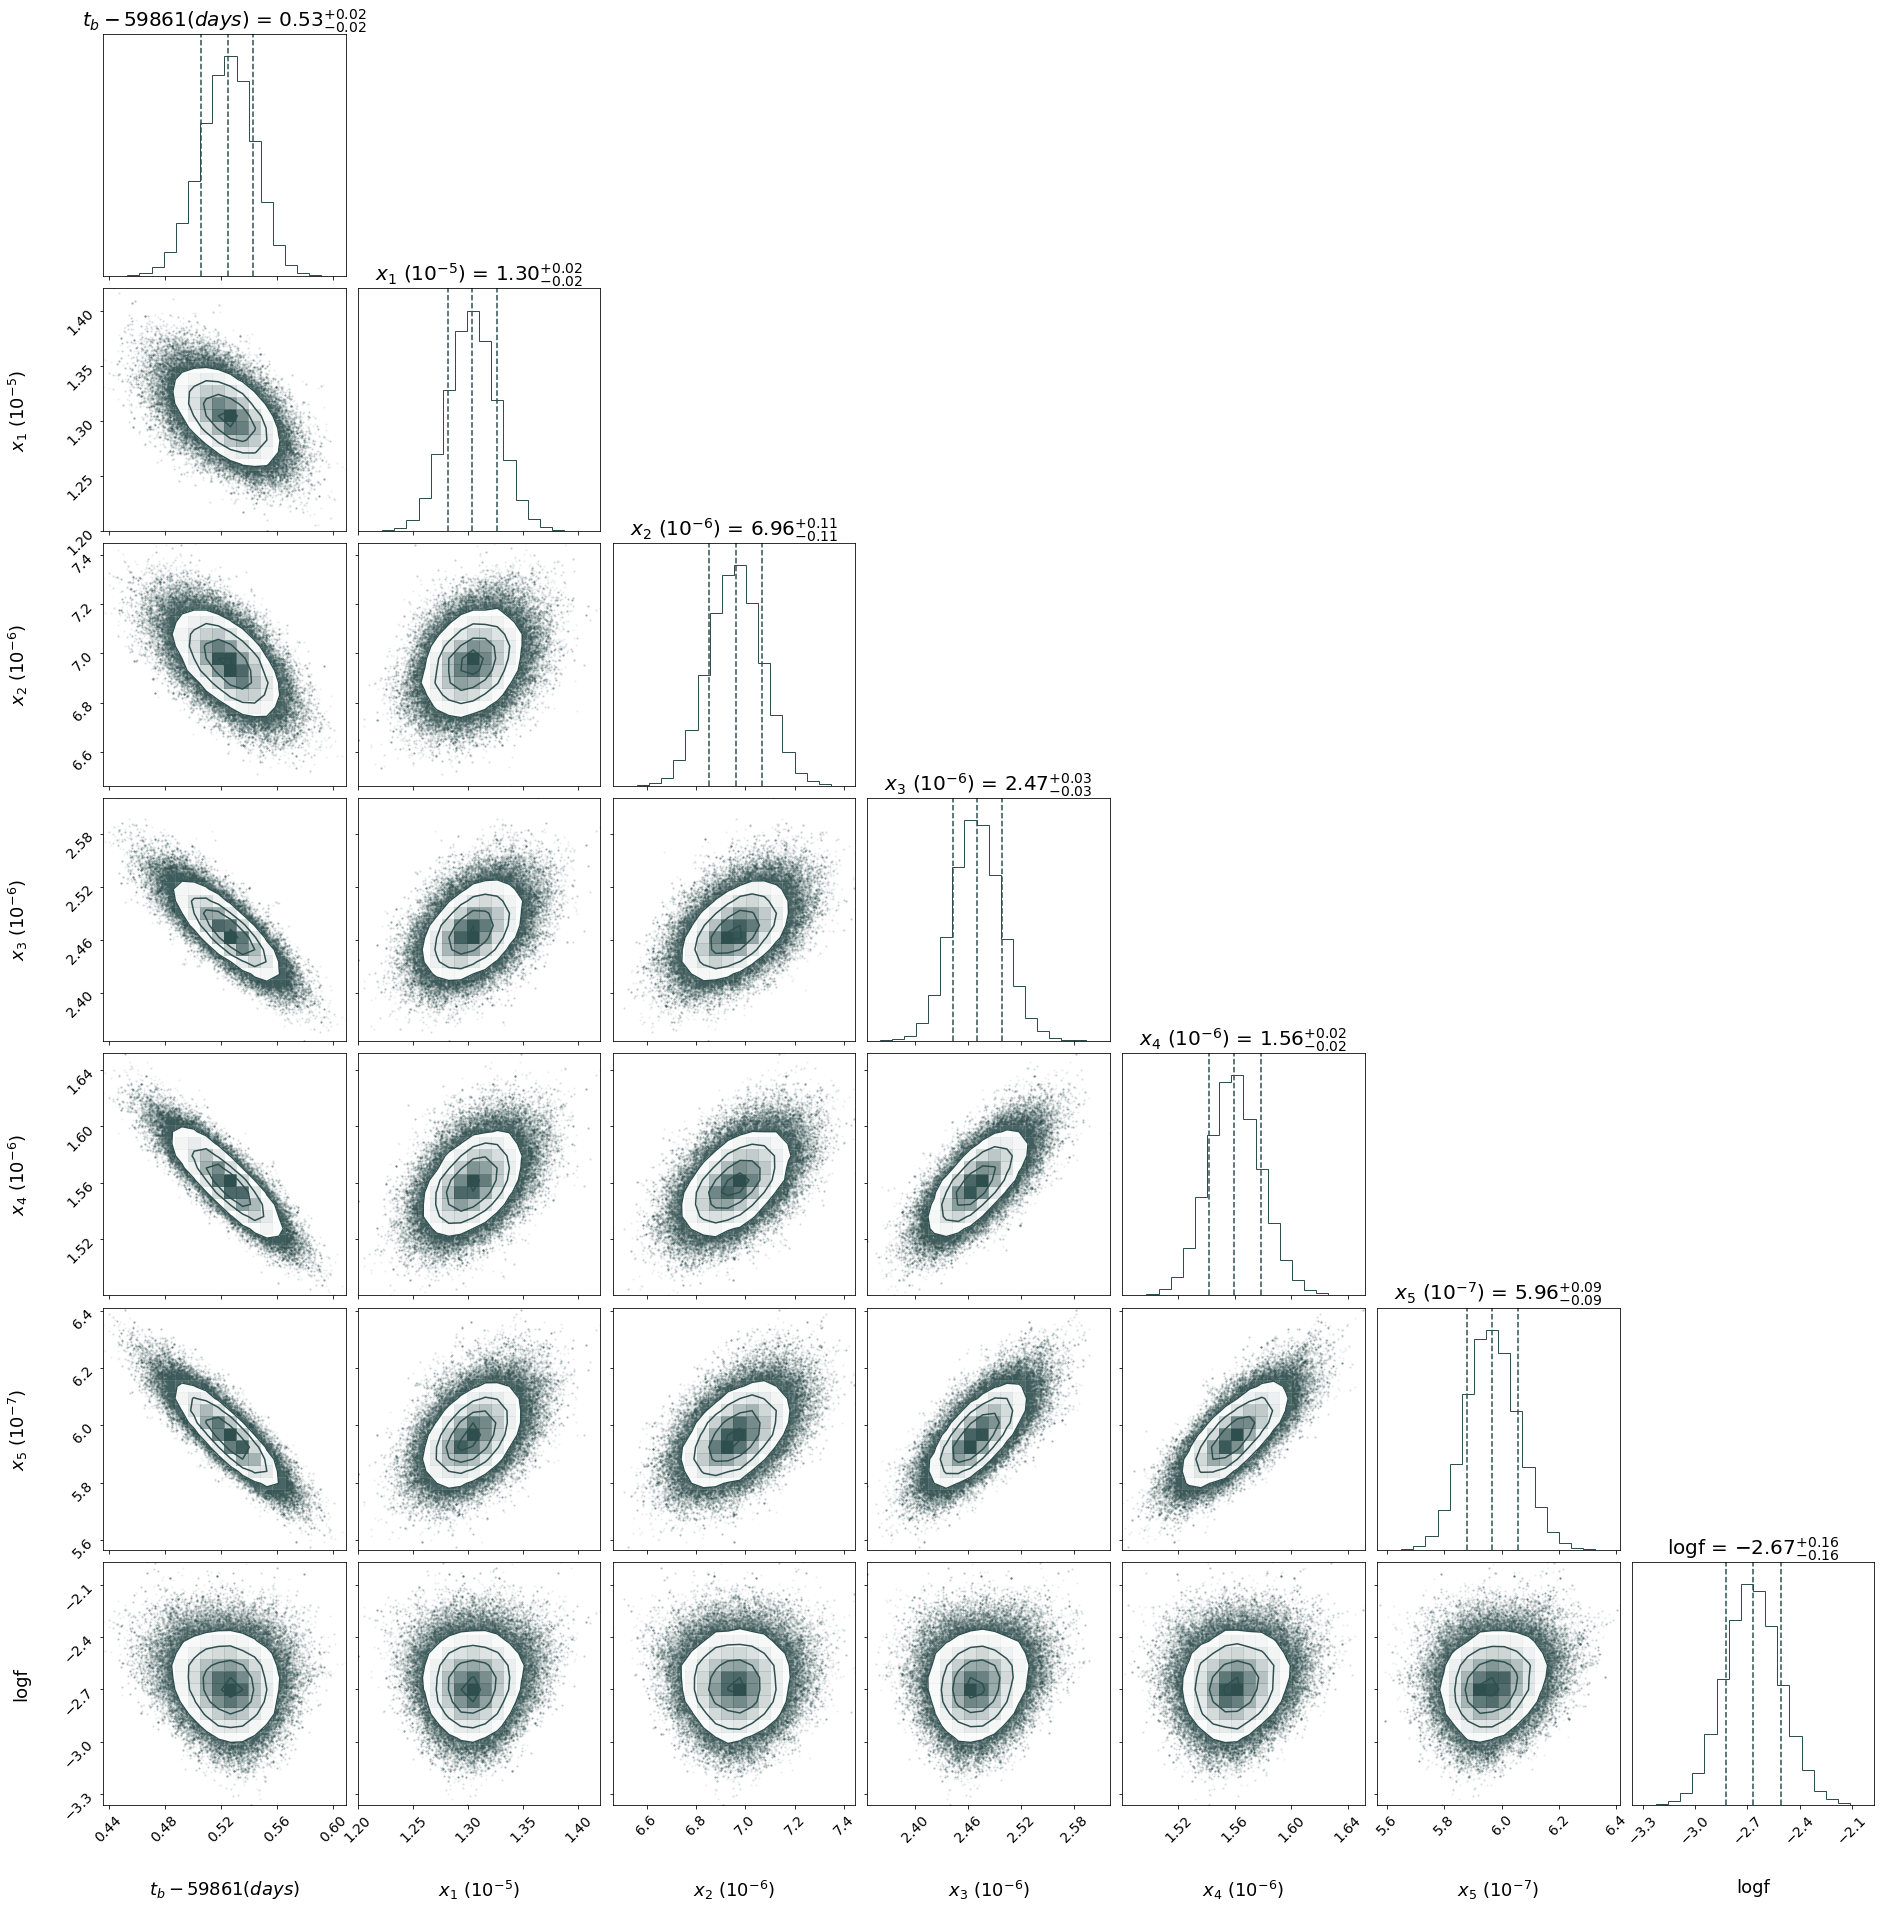

In [35]:
fig = corner.corner(chain_check,
                    quantiles=[0.16, 0.5, 0.84], 
                    labels=params_names, 
                    show_titles=True,
                    title_kwargs={"fontsize": 20.},
                    label_kwargs=dict(fontsize=18),
                    range=[percentage_to_plot] * ndim,
                    color='darkslategrey',
                    title_fmt=".2f")
fig.subplots_adjust(right=1.6,top=1.6)
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=14.)

# plt.savefig(path_plots+"cornerplot_expansion_300123.jpg",dpi=300,bbox_inches='tight')
plt.show()

# Plot of ring expansion (data and optimal model)

59861


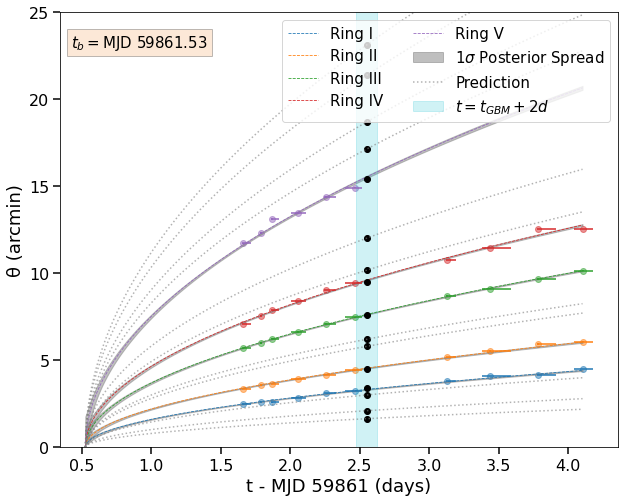

In [36]:
fig=plt.subplots(figsize=(10,8))

s_flag=18
cmap = plt.cm.tab10
p=[]
      
t0=tfit3[0][0]-t_ref   
   
tmin = t0
tmax=max(time)-t_ref
print(t_ref)
    
labels = ['Ring I', 'Ring II', 'Ring III', 'Ring IV', 'Ring V']

for i in range(0,len(ring_d)):
    
    x_model = np.linspace(tmin, tmax, 500)
    y_model = profiler.ring_rad(x_model, tfit3[0][i+1],t0)
    
    mask=(np.isnan(ring_d[i]))|(np.array(ring_d[i])==0.)
    t=np.array(time)[~mask]
    y=np.array(ring_d[i])[~mask]
    yerr=[]
    chain=[]
    
    for j in range(0,len(fgc3_ring[0][0])):
        chain.append([fgc3_ring[0][0][j][0]-t_ref,fgc3_ring[0][0][j][i+1]])
    chain=np.array(chain)
    for j in range(0,len(y)):
        yerr.append(fit_err[j][i])
    yerr=np.array(yerr)

    
    plt.subplot(111)
    p.append(plt.scatter(t-t_ref, y,color=cmap.colors[i],label='__nolabel__',alpha=0.5))
    
    for j in range(0,len(y)):
        plt.errorbar(t[j]-t_ref, y[j], xerr=np.array([[time_err_lo[j]],[time_err_hi[j]]]), yerr=np.array([[yerr[j][0]],[yerr[j][1]]]),fmt="none",capsize=0, ecolor=cmap.colors[i])

    plt.plot(x_model, y_model, "--", c=cmap.colors[i] ,label=labels[i],linewidth=0.8)
    
    med_model, spread = sample_walkers(10000,chain)  
    
    if i==len(ring_d)-1:
        plt.fill_between(x_model,med_model-1*spread,med_model+1*spread,color='gray',alpha=0.5,label=r'$1\sigma$ Posterior Spread')    
    else:
        plt.fill_between(x_model,med_model-1*spread,med_model+1*spread,color='gray',alpha=0.5,label="__nolabel__")    

#########################
# from stacked analysis #
tscale = 2.55 # scaled to tscale after 59861 MJD
rings_2d = np.array([1.645502,2.103281, 3.009615, 3.402610,4.505811,5.804634,
      6.211932,7.623904,9.521823,10.181886,12.025220,15.427883,17.149540,
   18.708306,21.390994, 23.139434]) # arcmin 

######################### 

x_2d=[profiler.d_dist(rings_2d[i],tscale,t0) for i in range(0,len(rings_2d))]
 
plt.plot((tscale)*np.ones(len(rings_2d)), rings_2d,'k o')

for i in range(0,len(rings_2d)):
    if i==0:
        plt.plot(x_model,profiler.ring_rad(x_model, x_2d[i],t0),linestyle=':',color=cmap.colors[7], label="Prediction",alpha=0.6)
    else:
        if i==3 or i==4 or i==7 or i==8 or i==11:
            pass
        else:
            plt.plot(x_model,profiler.ring_rad(x_model, x_2d[i],t0),linestyle=':',color=cmap.colors[7],alpha=0.6)
            
plt.fill_between(x_model,0.,2*max(rings_2d), where=((x_model>0.97*tscale)&(1.03*tscale>x_model)),color=cmap.colors[9],alpha=0.2,label="$t=t_{GBM}+2 d$")

fits=plt.legend(ncol=2,fontsize=s_flag-3,loc="upper right")
plt.ylim([0.,25.])

plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(which='major', width=1.5, length=7)
plt.tick_params(which='minor', width=1.5, length=4)


plt.xlabel("t - MJD %d"%(t_ref)+" (days)",fontsize=s_flag)
plt.ylabel("θ (arcmin)",fontsize=s_flag)
plt.text(tmin-0.1,23.,'$t_b=$MJD %.2f'%(t0+t_ref),fontsize=s_flag-3,bbox=dict(facecolor='sandybrown', alpha=0.25))
# plt.savefig(path_plots+'Ring_Radii-300123.jpg',dpi=300)
plt.show()